# Here we test how Learning Rate, Epochs, and Dense Layer size impact SHAP calculations in a Neural Network

In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
import shap

In [121]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_15236\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [122]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [123]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [124]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [125]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [126]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [127]:
data = data.sample(n=10000)

In [128]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    6968
1    1032
Name: count, dtype: int64
Test label
0    1741
1     259
Name: count, dtype: int64


In [129]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# Some error when sampling need to set to .values
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Networks

# Learning Rate at 5 Epochs

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_lr1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 166.89batch/s]


Epoch [1/5], Train Loss: 0.0618, Train Acc: 0.9753, Train F1: 0.9710


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 221.53batch/s]


Epoch [2/5], Train Loss: 0.0216, Train Acc: 0.9907, Train F1: 0.9906


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 204.25batch/s]


Epoch [3/5], Train Loss: 0.0202, Train Acc: 0.9895, Train F1: 0.9893


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 210.65batch/s]


Epoch [4/5], Train Loss: 0.0178, Train Acc: 0.9923, Train F1: 0.9922


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 209.14batch/s]


Epoch [5/5], Train Loss: 0.0171, Train Acc: 0.9919, Train F1: 0.9918


Testing: 100%|██████████| 16/16 [00:00<00:00, 286.83batch/s]


Test Loss: 0.0197, Test Accuracy: 0.9888, Test F1: 0.9884


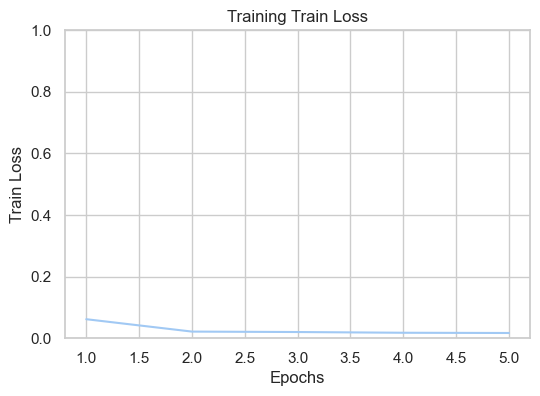

Epoch 1 Test


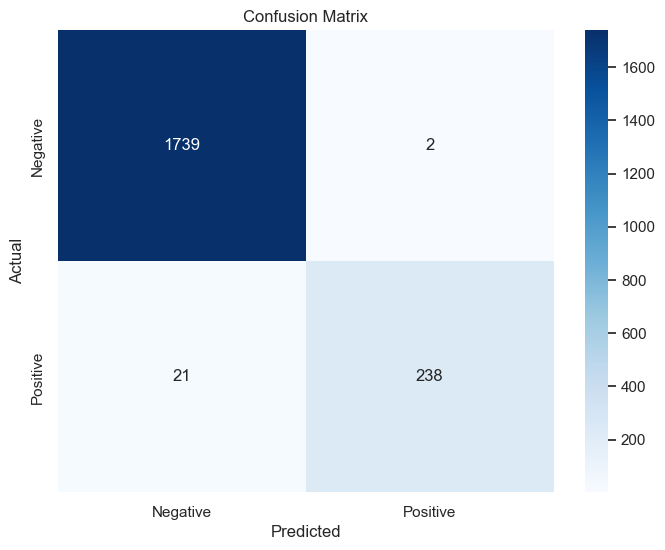

In [131]:
sampler = None
params = None
learning_rate = 0.1
epochs = 5
# Not saving.
save_factor = 100
model_lr1.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_lr1.test(test_loader)
plot_metrics(model_lr1.train_loss, len(model_lr1.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_lr1.test_predicted)

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/smote/'
model_lr2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 214.83batch/s]


Epoch [1/5], Train Loss: 0.0868, Train Acc: 0.9663, Train F1: 0.9577


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 219.64batch/s]


Epoch [2/5], Train Loss: 0.0218, Train Acc: 0.9900, Train F1: 0.9899


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 208.70batch/s]


Epoch [3/5], Train Loss: 0.0198, Train Acc: 0.9906, Train F1: 0.9905


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 210.70batch/s]


Epoch [4/5], Train Loss: 0.0178, Train Acc: 0.9914, Train F1: 0.9914


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 230.37batch/s]


Epoch [5/5], Train Loss: 0.0160, Train Acc: 0.9924, Train F1: 0.9924


Testing: 100%|██████████| 16/16 [00:00<00:00, 331.38batch/s]


Test Loss: 0.0177, Test Accuracy: 0.9917, Test F1: 0.9916


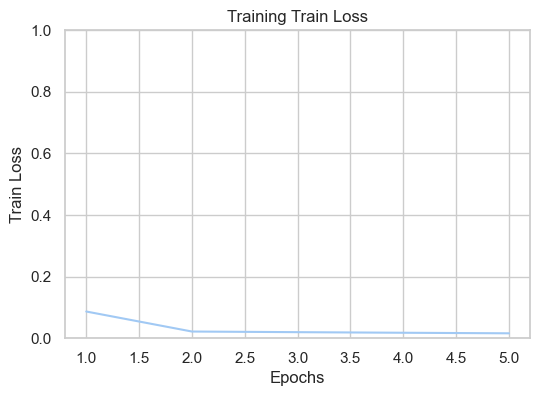

Epoch 1 Test


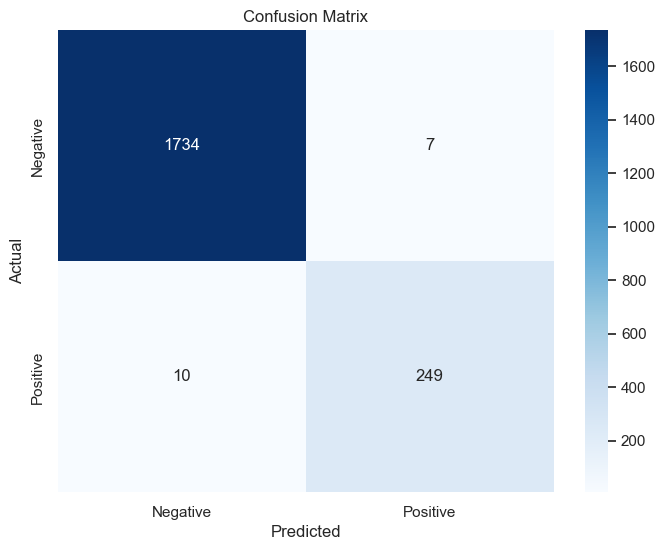

In [133]:
sampler = None
params = None
learning_rate = 0.01
epochs = 5
# Not saving.
save_factor = 100
model_lr2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_lr2.test(test_loader)
plot_metrics(model_lr2.train_loss, len(model_lr2.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_lr2.test_predicted)

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_lr3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 212.30batch/s]


Epoch [1/5], Train Loss: 0.0905, Train Acc: 0.9685, Train F1: 0.9612


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 231.03batch/s]


Epoch [2/5], Train Loss: 0.0224, Train Acc: 0.9892, Train F1: 0.9891


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 243.40batch/s]


Epoch [3/5], Train Loss: 0.0187, Train Acc: 0.9909, Train F1: 0.9909


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 209.67batch/s]


Epoch [4/5], Train Loss: 0.0173, Train Acc: 0.9932, Train F1: 0.9931


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 234.08batch/s]


Epoch [5/5], Train Loss: 0.0173, Train Acc: 0.9921, Train F1: 0.9920


Testing: 100%|██████████| 16/16 [00:00<00:00, 319.60batch/s]

Test Loss: 0.0175, Test Accuracy: 0.9917, Test F1: 0.9915


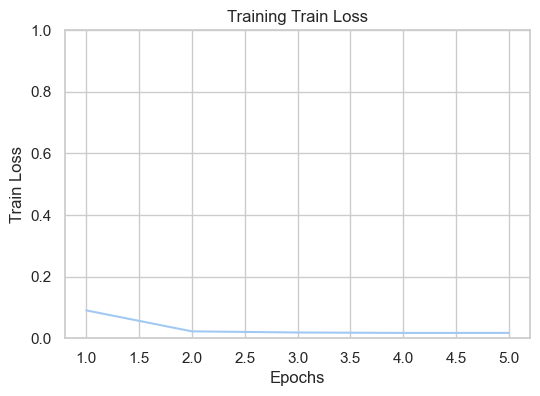

Epoch 1 Test


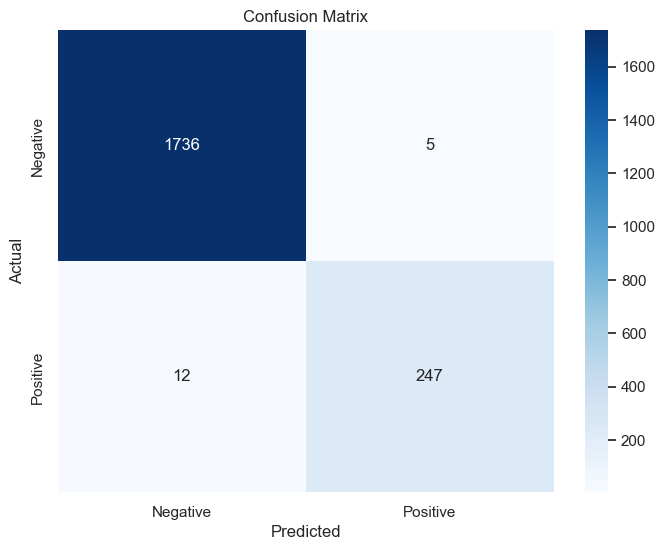

In [135]:
sampler = None
params = None
learning_rate = 0.01
epochs = 5
# Not saving.
save_factor = 100
model_lr3.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_lr3.test(test_loader)
plot_metrics(model_lr3.train_loss, len(model_lr3.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_lr3.test_predicted)

# Epochs at 0.01 Learning Rate

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_ep1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 226.90batch/s]


Epoch [1/10], Train Loss: 0.0945, Train Acc: 0.9660, Train F1: 0.9579


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 217.13batch/s]


Epoch [2/10], Train Loss: 0.0227, Train Acc: 0.9896, Train F1: 0.9896


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 225.42batch/s]


Epoch [3/10], Train Loss: 0.0196, Train Acc: 0.9908, Train F1: 0.9907


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 241.80batch/s]


Epoch [4/10], Train Loss: 0.0191, Train Acc: 0.9912, Train F1: 0.9911


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 231.02batch/s]


Epoch [5/10], Train Loss: 0.0186, Train Acc: 0.9908, Train F1: 0.9908


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 231.05batch/s]


Epoch [6/10], Train Loss: 0.0167, Train Acc: 0.9923, Train F1: 0.9922


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 237.58batch/s]


Epoch [7/10], Train Loss: 0.0153, Train Acc: 0.9924, Train F1: 0.9924


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 218.92batch/s]


Epoch [8/10], Train Loss: 0.0145, Train Acc: 0.9936, Train F1: 0.9935


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 234.93batch/s]


Epoch [9/10], Train Loss: 0.0141, Train Acc: 0.9934, Train F1: 0.9934


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 234.83batch/s]


Epoch [10/10], Train Loss: 0.0129, Train Acc: 0.9944, Train F1: 0.9944


Testing: 100%|██████████| 16/16 [00:00<00:00, 297.05batch/s]

Test Loss: 0.0162, Test Accuracy: 0.9924, Test F1: 0.9922


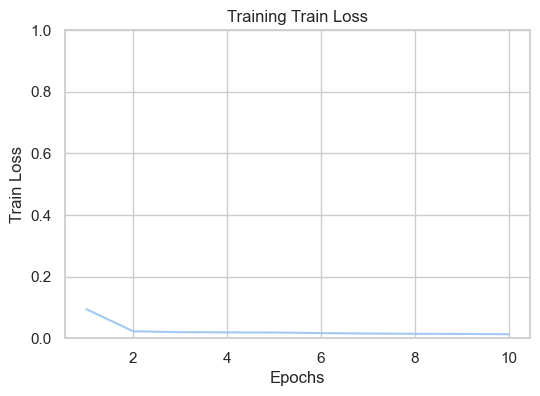

Epoch 1 Test


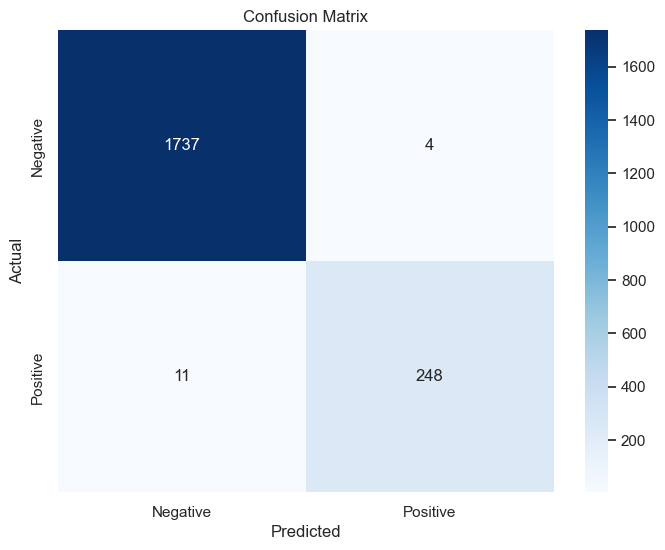

In [137]:
sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_ep1.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_ep1.test(test_loader)
plot_metrics(model_ep1.train_loss, len(model_ep1.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_ep1.test_predicted)

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_ep2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/50: 100%|██████████| 63/63 [00:00<00:00, 230.91batch/s]


Epoch [1/50], Train Loss: 0.0896, Train Acc: 0.9684, Train F1: 0.9613


Epoch 2/50: 100%|██████████| 63/63 [00:00<00:00, 230.18batch/s]


Epoch [2/50], Train Loss: 0.0222, Train Acc: 0.9892, Train F1: 0.9892


Epoch 3/50: 100%|██████████| 63/63 [00:00<00:00, 227.82batch/s]


Epoch [3/50], Train Loss: 0.0195, Train Acc: 0.9909, Train F1: 0.9909


Epoch 4/50: 100%|██████████| 63/63 [00:00<00:00, 237.40batch/s]


Epoch [4/50], Train Loss: 0.0172, Train Acc: 0.9921, Train F1: 0.9920


Epoch 5/50: 100%|██████████| 63/63 [00:00<00:00, 224.05batch/s]


Epoch [5/50], Train Loss: 0.0206, Train Acc: 0.9908, Train F1: 0.9907


Epoch 6/50: 100%|██████████| 63/63 [00:00<00:00, 206.31batch/s]


Epoch [6/50], Train Loss: 0.0161, Train Acc: 0.9931, Train F1: 0.9930


Epoch 7/50: 100%|██████████| 63/63 [00:00<00:00, 242.70batch/s]


Epoch [7/50], Train Loss: 0.0162, Train Acc: 0.9928, Train F1: 0.9928


Epoch 8/50: 100%|██████████| 63/63 [00:00<00:00, 218.96batch/s]


Epoch [8/50], Train Loss: 0.0132, Train Acc: 0.9938, Train F1: 0.9937


Epoch 9/50: 100%|██████████| 63/63 [00:00<00:00, 228.28batch/s]


Epoch [9/50], Train Loss: 0.0152, Train Acc: 0.9939, Train F1: 0.9939


Epoch 10/50: 100%|██████████| 63/63 [00:00<00:00, 218.18batch/s]


Epoch [10/50], Train Loss: 0.0125, Train Acc: 0.9952, Train F1: 0.9951


Epoch 11/50: 100%|██████████| 63/63 [00:00<00:00, 238.74batch/s]


Epoch [11/50], Train Loss: 0.0127, Train Acc: 0.9945, Train F1: 0.9945


Epoch 12/50: 100%|██████████| 63/63 [00:00<00:00, 243.05batch/s]


Epoch [12/50], Train Loss: 0.0111, Train Acc: 0.9950, Train F1: 0.9950


Epoch 13/50: 100%|██████████| 63/63 [00:00<00:00, 218.81batch/s]


Epoch [13/50], Train Loss: 0.0116, Train Acc: 0.9954, Train F1: 0.9954


Epoch 14/50: 100%|██████████| 63/63 [00:00<00:00, 231.19batch/s]


Epoch [14/50], Train Loss: 0.0107, Train Acc: 0.9958, Train F1: 0.9957


Epoch 15/50: 100%|██████████| 63/63 [00:00<00:00, 233.31batch/s]


Epoch [15/50], Train Loss: 0.0095, Train Acc: 0.9955, Train F1: 0.9955


Epoch 16/50: 100%|██████████| 63/63 [00:00<00:00, 224.75batch/s]


Epoch [16/50], Train Loss: 0.0088, Train Acc: 0.9958, Train F1: 0.9957


Epoch 17/50: 100%|██████████| 63/63 [00:00<00:00, 215.47batch/s]


Epoch [17/50], Train Loss: 0.0076, Train Acc: 0.9968, Train F1: 0.9967


Epoch 18/50: 100%|██████████| 63/63 [00:00<00:00, 228.42batch/s]


Epoch [18/50], Train Loss: 0.0080, Train Acc: 0.9967, Train F1: 0.9966


Epoch 19/50: 100%|██████████| 63/63 [00:00<00:00, 235.99batch/s]


Epoch [19/50], Train Loss: 0.0080, Train Acc: 0.9964, Train F1: 0.9964


Epoch 20/50: 100%|██████████| 63/63 [00:00<00:00, 235.82batch/s]


Epoch [20/50], Train Loss: 0.0077, Train Acc: 0.9969, Train F1: 0.9969


Epoch 21/50: 100%|██████████| 63/63 [00:00<00:00, 207.88batch/s]


Epoch [21/50], Train Loss: 0.0081, Train Acc: 0.9964, Train F1: 0.9964


Epoch 22/50: 100%|██████████| 63/63 [00:00<00:00, 233.03batch/s]


Epoch [22/50], Train Loss: 0.0071, Train Acc: 0.9971, Train F1: 0.9971


Epoch 23/50: 100%|██████████| 63/63 [00:00<00:00, 196.21batch/s]


Epoch [23/50], Train Loss: 0.0067, Train Acc: 0.9964, Train F1: 0.9964


Epoch 24/50: 100%|██████████| 63/63 [00:00<00:00, 184.50batch/s]


Epoch [24/50], Train Loss: 0.0074, Train Acc: 0.9960, Train F1: 0.9960


Epoch 25/50: 100%|██████████| 63/63 [00:00<00:00, 226.57batch/s]


Epoch [25/50], Train Loss: 0.0057, Train Acc: 0.9978, Train F1: 0.9978


Epoch 26/50: 100%|██████████| 63/63 [00:00<00:00, 214.74batch/s]


Epoch [26/50], Train Loss: 0.0055, Train Acc: 0.9978, Train F1: 0.9977


Epoch 27/50: 100%|██████████| 63/63 [00:00<00:00, 213.50batch/s]


Epoch [27/50], Train Loss: 0.0052, Train Acc: 0.9976, Train F1: 0.9976


Epoch 28/50: 100%|██████████| 63/63 [00:00<00:00, 212.62batch/s]


Epoch [28/50], Train Loss: 0.0042, Train Acc: 0.9988, Train F1: 0.9987


Epoch 29/50: 100%|██████████| 63/63 [00:00<00:00, 231.12batch/s]


Epoch [29/50], Train Loss: 0.0052, Train Acc: 0.9974, Train F1: 0.9974


Epoch 30/50: 100%|██████████| 63/63 [00:00<00:00, 206.91batch/s]


Epoch [30/50], Train Loss: 0.0048, Train Acc: 0.9976, Train F1: 0.9976


Epoch 31/50: 100%|██████████| 63/63 [00:00<00:00, 207.32batch/s]


Epoch [31/50], Train Loss: 0.0040, Train Acc: 0.9984, Train F1: 0.9984


Epoch 32/50: 100%|██████████| 63/63 [00:00<00:00, 202.02batch/s]


Epoch [32/50], Train Loss: 0.0046, Train Acc: 0.9979, Train F1: 0.9979


Epoch 33/50: 100%|██████████| 63/63 [00:00<00:00, 211.39batch/s]


Epoch [33/50], Train Loss: 0.0039, Train Acc: 0.9984, Train F1: 0.9984


Epoch 34/50: 100%|██████████| 63/63 [00:00<00:00, 169.49batch/s]


Epoch [34/50], Train Loss: 0.0045, Train Acc: 0.9980, Train F1: 0.9980


Epoch 35/50: 100%|██████████| 63/63 [00:00<00:00, 199.99batch/s]


Epoch [35/50], Train Loss: 0.0036, Train Acc: 0.9988, Train F1: 0.9988


Epoch 36/50: 100%|██████████| 63/63 [00:00<00:00, 217.35batch/s]


Epoch [36/50], Train Loss: 0.0028, Train Acc: 0.9989, Train F1: 0.9989


Epoch 37/50: 100%|██████████| 63/63 [00:00<00:00, 218.98batch/s]


Epoch [37/50], Train Loss: 0.0051, Train Acc: 0.9978, Train F1: 0.9978


Epoch 38/50: 100%|██████████| 63/63 [00:00<00:00, 223.72batch/s]


Epoch [38/50], Train Loss: 0.0048, Train Acc: 0.9979, Train F1: 0.9979


Epoch 39/50: 100%|██████████| 63/63 [00:00<00:00, 231.17batch/s]


Epoch [39/50], Train Loss: 0.0046, Train Acc: 0.9983, Train F1: 0.9983


Epoch 40/50: 100%|██████████| 63/63 [00:00<00:00, 215.00batch/s]


Epoch [40/50], Train Loss: 0.0031, Train Acc: 0.9986, Train F1: 0.9986


Epoch 41/50: 100%|██████████| 63/63 [00:00<00:00, 239.99batch/s]


Epoch [41/50], Train Loss: 0.0035, Train Acc: 0.9985, Train F1: 0.9985


Epoch 42/50: 100%|██████████| 63/63 [00:00<00:00, 241.76batch/s]


Epoch [42/50], Train Loss: 0.0032, Train Acc: 0.9989, Train F1: 0.9989


Epoch 43/50: 100%|██████████| 63/63 [00:00<00:00, 241.88batch/s]


Epoch [43/50], Train Loss: 0.0022, Train Acc: 0.9993, Train F1: 0.9992


Epoch 44/50: 100%|██████████| 63/63 [00:00<00:00, 230.10batch/s]


Epoch [44/50], Train Loss: 0.0030, Train Acc: 0.9989, Train F1: 0.9989


Epoch 45/50: 100%|██████████| 63/63 [00:00<00:00, 245.75batch/s]


Epoch [45/50], Train Loss: 0.0027, Train Acc: 0.9988, Train F1: 0.9987


Epoch 46/50: 100%|██████████| 63/63 [00:00<00:00, 242.72batch/s]


Epoch [46/50], Train Loss: 0.0024, Train Acc: 0.9989, Train F1: 0.9989


Epoch 47/50: 100%|██████████| 63/63 [00:00<00:00, 221.79batch/s]


Epoch [47/50], Train Loss: 0.0034, Train Acc: 0.9981, Train F1: 0.9981


Epoch 48/50: 100%|██████████| 63/63 [00:00<00:00, 236.28batch/s]


Epoch [48/50], Train Loss: 0.0024, Train Acc: 0.9993, Train F1: 0.9992


Epoch 49/50: 100%|██████████| 63/63 [00:00<00:00, 227.38batch/s]


Epoch [49/50], Train Loss: 0.0024, Train Acc: 0.9993, Train F1: 0.9993


Epoch 50/50: 100%|██████████| 63/63 [00:00<00:00, 242.38batch/s]


Epoch [50/50], Train Loss: 0.0021, Train Acc: 0.9991, Train F1: 0.9991


Testing: 100%|██████████| 16/16 [00:00<00:00, 364.53batch/s]

Test Loss: 0.0251, Test Accuracy: 0.9934, Test F1: 0.9933


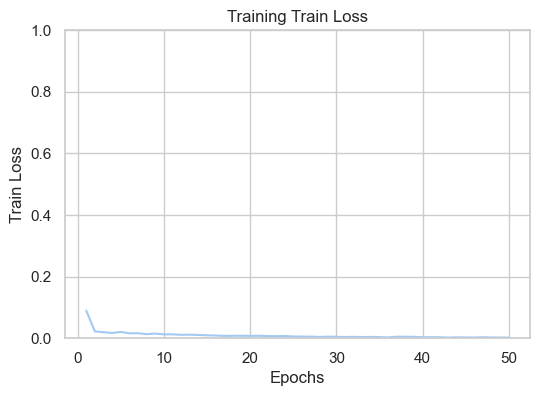

Epoch 1 Test


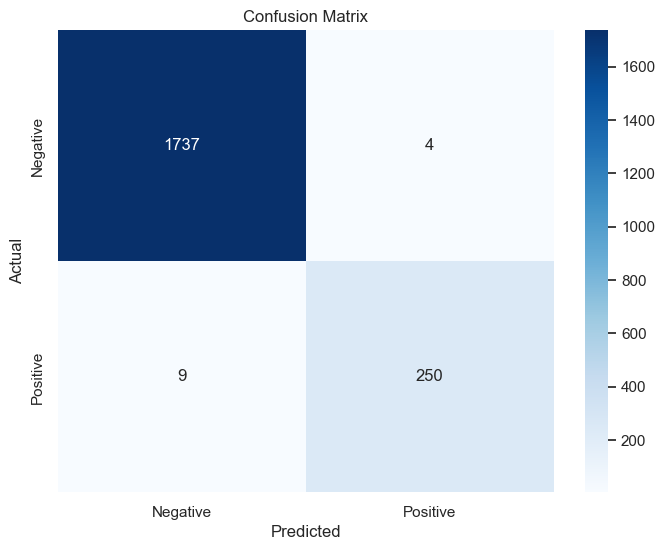

In [139]:
sampler = None
params = None
learning_rate = 0.01
epochs = 50
# Not saving.
save_factor = 100
model_ep2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_ep2.test(test_loader)
plot_metrics(model_ep2.train_loss, len(model_ep2.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_ep2.test_predicted)

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_ep3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/100: 100%|██████████| 63/63 [00:00<00:00, 217.81batch/s]


Epoch [1/100], Train Loss: 0.0898, Train Acc: 0.9666, Train F1: 0.9594


Epoch 2/100: 100%|██████████| 63/63 [00:00<00:00, 236.21batch/s]


Epoch [2/100], Train Loss: 0.0229, Train Acc: 0.9880, Train F1: 0.9879


Epoch 3/100: 100%|██████████| 63/63 [00:00<00:00, 241.66batch/s]


Epoch [3/100], Train Loss: 0.0207, Train Acc: 0.9898, Train F1: 0.9898


Epoch 4/100: 100%|██████████| 63/63 [00:00<00:00, 195.58batch/s]


Epoch [4/100], Train Loss: 0.0180, Train Acc: 0.9914, Train F1: 0.9914


Epoch 5/100: 100%|██████████| 63/63 [00:00<00:00, 229.08batch/s]


Epoch [5/100], Train Loss: 0.0170, Train Acc: 0.9919, Train F1: 0.9919


Epoch 6/100: 100%|██████████| 63/63 [00:00<00:00, 233.74batch/s]


Epoch [6/100], Train Loss: 0.0161, Train Acc: 0.9923, Train F1: 0.9922


Epoch 7/100: 100%|██████████| 63/63 [00:00<00:00, 238.91batch/s]


Epoch [7/100], Train Loss: 0.0152, Train Acc: 0.9931, Train F1: 0.9930


Epoch 8/100: 100%|██████████| 63/63 [00:00<00:00, 221.57batch/s]


Epoch [8/100], Train Loss: 0.0141, Train Acc: 0.9937, Train F1: 0.9936


Epoch 9/100: 100%|██████████| 63/63 [00:00<00:00, 235.77batch/s]


Epoch [9/100], Train Loss: 0.0149, Train Acc: 0.9932, Train F1: 0.9931


Epoch 10/100: 100%|██████████| 63/63 [00:00<00:00, 237.29batch/s]


Epoch [10/100], Train Loss: 0.0130, Train Acc: 0.9936, Train F1: 0.9935


Epoch 11/100: 100%|██████████| 63/63 [00:00<00:00, 234.25batch/s]


Epoch [11/100], Train Loss: 0.0136, Train Acc: 0.9942, Train F1: 0.9941


Epoch 12/100: 100%|██████████| 63/63 [00:00<00:00, 222.82batch/s]


Epoch [12/100], Train Loss: 0.0130, Train Acc: 0.9945, Train F1: 0.9945


Epoch 13/100: 100%|██████████| 63/63 [00:00<00:00, 227.84batch/s]


Epoch [13/100], Train Loss: 0.0109, Train Acc: 0.9953, Train F1: 0.9952


Epoch 14/100: 100%|██████████| 63/63 [00:00<00:00, 232.74batch/s]


Epoch [14/100], Train Loss: 0.0102, Train Acc: 0.9958, Train F1: 0.9957


Epoch 15/100: 100%|██████████| 63/63 [00:00<00:00, 231.00batch/s]


Epoch [15/100], Train Loss: 0.0108, Train Acc: 0.9952, Train F1: 0.9951


Epoch 16/100: 100%|██████████| 63/63 [00:00<00:00, 228.27batch/s]


Epoch [16/100], Train Loss: 0.0089, Train Acc: 0.9957, Train F1: 0.9956


Epoch 17/100: 100%|██████████| 63/63 [00:00<00:00, 206.10batch/s]


Epoch [17/100], Train Loss: 0.0076, Train Acc: 0.9968, Train F1: 0.9967


Epoch 18/100: 100%|██████████| 63/63 [00:00<00:00, 232.08batch/s]


Epoch [18/100], Train Loss: 0.0073, Train Acc: 0.9970, Train F1: 0.9970


Epoch 19/100: 100%|██████████| 63/63 [00:00<00:00, 222.60batch/s]


Epoch [19/100], Train Loss: 0.0079, Train Acc: 0.9967, Train F1: 0.9966


Epoch 20/100: 100%|██████████| 63/63 [00:00<00:00, 233.79batch/s]


Epoch [20/100], Train Loss: 0.0067, Train Acc: 0.9971, Train F1: 0.9971


Epoch 21/100: 100%|██████████| 63/63 [00:00<00:00, 238.60batch/s]


Epoch [21/100], Train Loss: 0.0062, Train Acc: 0.9969, Train F1: 0.9969


Epoch 22/100: 100%|██████████| 63/63 [00:00<00:00, 230.37batch/s]


Epoch [22/100], Train Loss: 0.0053, Train Acc: 0.9976, Train F1: 0.9976


Epoch 23/100: 100%|██████████| 63/63 [00:00<00:00, 220.19batch/s]


Epoch [23/100], Train Loss: 0.0060, Train Acc: 0.9975, Train F1: 0.9975


Epoch 24/100: 100%|██████████| 63/63 [00:00<00:00, 237.21batch/s]


Epoch [24/100], Train Loss: 0.0056, Train Acc: 0.9971, Train F1: 0.9971


Epoch 25/100: 100%|██████████| 63/63 [00:00<00:00, 240.92batch/s]


Epoch [25/100], Train Loss: 0.0064, Train Acc: 0.9970, Train F1: 0.9970


Epoch 26/100: 100%|██████████| 63/63 [00:00<00:00, 235.87batch/s]


Epoch [26/100], Train Loss: 0.0053, Train Acc: 0.9973, Train F1: 0.9973


Epoch 27/100: 100%|██████████| 63/63 [00:00<00:00, 230.72batch/s]


Epoch [27/100], Train Loss: 0.0051, Train Acc: 0.9979, Train F1: 0.9979


Epoch 28/100: 100%|██████████| 63/63 [00:00<00:00, 242.95batch/s]


Epoch [28/100], Train Loss: 0.0061, Train Acc: 0.9968, Train F1: 0.9968


Epoch 29/100: 100%|██████████| 63/63 [00:00<00:00, 252.87batch/s]


Epoch [29/100], Train Loss: 0.0044, Train Acc: 0.9984, Train F1: 0.9984


Epoch 30/100: 100%|██████████| 63/63 [00:00<00:00, 198.49batch/s]


Epoch [30/100], Train Loss: 0.0046, Train Acc: 0.9978, Train F1: 0.9977


Epoch 31/100: 100%|██████████| 63/63 [00:00<00:00, 236.30batch/s]


Epoch [31/100], Train Loss: 0.0041, Train Acc: 0.9981, Train F1: 0.9981


Epoch 32/100: 100%|██████████| 63/63 [00:00<00:00, 239.30batch/s]


Epoch [32/100], Train Loss: 0.0035, Train Acc: 0.9981, Train F1: 0.9981


Epoch 33/100: 100%|██████████| 63/63 [00:00<00:00, 222.51batch/s]


Epoch [33/100], Train Loss: 0.0032, Train Acc: 0.9984, Train F1: 0.9984


Epoch 34/100: 100%|██████████| 63/63 [00:00<00:00, 229.69batch/s]


Epoch [34/100], Train Loss: 0.0033, Train Acc: 0.9983, Train F1: 0.9983


Epoch 35/100: 100%|██████████| 63/63 [00:00<00:00, 213.06batch/s]


Epoch [35/100], Train Loss: 0.0047, Train Acc: 0.9980, Train F1: 0.9980


Epoch 36/100: 100%|██████████| 63/63 [00:00<00:00, 230.22batch/s]


Epoch [36/100], Train Loss: 0.0034, Train Acc: 0.9983, Train F1: 0.9983


Epoch 37/100: 100%|██████████| 63/63 [00:00<00:00, 223.10batch/s]


Epoch [37/100], Train Loss: 0.0069, Train Acc: 0.9974, Train F1: 0.9974


Epoch 38/100: 100%|██████████| 63/63 [00:00<00:00, 238.19batch/s]


Epoch [38/100], Train Loss: 0.0033, Train Acc: 0.9985, Train F1: 0.9985


Epoch 39/100: 100%|██████████| 63/63 [00:00<00:00, 227.89batch/s]


Epoch [39/100], Train Loss: 0.0029, Train Acc: 0.9988, Train F1: 0.9987


Epoch 40/100: 100%|██████████| 63/63 [00:00<00:00, 238.74batch/s]


Epoch [40/100], Train Loss: 0.0028, Train Acc: 0.9988, Train F1: 0.9988


Epoch 41/100: 100%|██████████| 63/63 [00:00<00:00, 230.74batch/s]


Epoch [41/100], Train Loss: 0.0029, Train Acc: 0.9989, Train F1: 0.9989


Epoch 42/100: 100%|██████████| 63/63 [00:00<00:00, 242.15batch/s]


Epoch [42/100], Train Loss: 0.0029, Train Acc: 0.9985, Train F1: 0.9985


Epoch 43/100: 100%|██████████| 63/63 [00:00<00:00, 237.08batch/s]


Epoch [43/100], Train Loss: 0.0038, Train Acc: 0.9981, Train F1: 0.9981


Epoch 44/100: 100%|██████████| 63/63 [00:00<00:00, 210.65batch/s]


Epoch [44/100], Train Loss: 0.0029, Train Acc: 0.9985, Train F1: 0.9985


Epoch 45/100: 100%|██████████| 63/63 [00:00<00:00, 236.54batch/s]


Epoch [45/100], Train Loss: 0.0025, Train Acc: 0.9986, Train F1: 0.9986


Epoch 46/100: 100%|██████████| 63/63 [00:00<00:00, 239.66batch/s]


Epoch [46/100], Train Loss: 0.0029, Train Acc: 0.9985, Train F1: 0.9985


Epoch 47/100: 100%|██████████| 63/63 [00:00<00:00, 236.12batch/s]


Epoch [47/100], Train Loss: 0.0019, Train Acc: 0.9993, Train F1: 0.9992


Epoch 48/100: 100%|██████████| 63/63 [00:00<00:00, 239.82batch/s]


Epoch [48/100], Train Loss: 0.0021, Train Acc: 0.9989, Train F1: 0.9989


Epoch 49/100: 100%|██████████| 63/63 [00:00<00:00, 246.02batch/s]


Epoch [49/100], Train Loss: 0.0030, Train Acc: 0.9988, Train F1: 0.9988


Epoch 50/100: 100%|██████████| 63/63 [00:00<00:00, 248.38batch/s]


Epoch [50/100], Train Loss: 0.0026, Train Acc: 0.9989, Train F1: 0.9989


Epoch 51/100: 100%|██████████| 63/63 [00:00<00:00, 234.66batch/s]


Epoch [51/100], Train Loss: 0.0024, Train Acc: 0.9990, Train F1: 0.9990


Epoch 52/100: 100%|██████████| 63/63 [00:00<00:00, 235.48batch/s]


Epoch [52/100], Train Loss: 0.0024, Train Acc: 0.9990, Train F1: 0.9990


Epoch 53/100: 100%|██████████| 63/63 [00:00<00:00, 225.98batch/s]


Epoch [53/100], Train Loss: 0.0016, Train Acc: 0.9991, Train F1: 0.9991


Epoch 54/100: 100%|██████████| 63/63 [00:00<00:00, 236.37batch/s]


Epoch [54/100], Train Loss: 0.0018, Train Acc: 0.9990, Train F1: 0.9990


Epoch 55/100: 100%|██████████| 63/63 [00:00<00:00, 240.39batch/s]


Epoch [55/100], Train Loss: 0.0022, Train Acc: 0.9994, Train F1: 0.9994


Epoch 56/100: 100%|██████████| 63/63 [00:00<00:00, 234.46batch/s]


Epoch [56/100], Train Loss: 0.0043, Train Acc: 0.9983, Train F1: 0.9982


Epoch 57/100: 100%|██████████| 63/63 [00:00<00:00, 212.06batch/s]


Epoch [57/100], Train Loss: 0.0023, Train Acc: 0.9993, Train F1: 0.9993


Epoch 58/100: 100%|██████████| 63/63 [00:00<00:00, 243.77batch/s]


Epoch [58/100], Train Loss: 0.0029, Train Acc: 0.9991, Train F1: 0.9991


Epoch 59/100: 100%|██████████| 63/63 [00:00<00:00, 232.52batch/s]


Epoch [59/100], Train Loss: 0.0017, Train Acc: 0.9994, Train F1: 0.9994


Epoch 60/100: 100%|██████████| 63/63 [00:00<00:00, 241.40batch/s]


Epoch [60/100], Train Loss: 0.0015, Train Acc: 0.9994, Train F1: 0.9994


Epoch 61/100: 100%|██████████| 63/63 [00:00<00:00, 253.91batch/s]


Epoch [61/100], Train Loss: 0.0015, Train Acc: 0.9993, Train F1: 0.9993


Epoch 62/100: 100%|██████████| 63/63 [00:00<00:00, 222.37batch/s]


Epoch [62/100], Train Loss: 0.0015, Train Acc: 0.9993, Train F1: 0.9993


Epoch 63/100: 100%|██████████| 63/63 [00:00<00:00, 231.91batch/s]


Epoch [63/100], Train Loss: 0.0013, Train Acc: 0.9996, Train F1: 0.9996


Epoch 64/100: 100%|██████████| 63/63 [00:00<00:00, 240.60batch/s]


Epoch [64/100], Train Loss: 0.0013, Train Acc: 0.9994, Train F1: 0.9994


Epoch 65/100: 100%|██████████| 63/63 [00:00<00:00, 241.16batch/s]


Epoch [65/100], Train Loss: 0.0017, Train Acc: 0.9990, Train F1: 0.9990


Epoch 66/100: 100%|██████████| 63/63 [00:00<00:00, 229.23batch/s]


Epoch [66/100], Train Loss: 0.0009, Train Acc: 0.9998, Train F1: 0.9998


Epoch 67/100: 100%|██████████| 63/63 [00:00<00:00, 223.46batch/s]


Epoch [67/100], Train Loss: 0.0015, Train Acc: 0.9991, Train F1: 0.9991


Epoch 68/100: 100%|██████████| 63/63 [00:00<00:00, 242.75batch/s]


Epoch [68/100], Train Loss: 0.0008, Train Acc: 0.9996, Train F1: 0.9996


Epoch 69/100: 100%|██████████| 63/63 [00:00<00:00, 218.89batch/s]


Epoch [69/100], Train Loss: 0.0015, Train Acc: 0.9994, Train F1: 0.9994


Epoch 70/100: 100%|██████████| 63/63 [00:00<00:00, 227.73batch/s]


Epoch [70/100], Train Loss: 0.0012, Train Acc: 0.9995, Train F1: 0.9995


Epoch 71/100: 100%|██████████| 63/63 [00:00<00:00, 234.89batch/s]


Epoch [71/100], Train Loss: 0.0010, Train Acc: 0.9994, Train F1: 0.9994


Epoch 72/100: 100%|██████████| 63/63 [00:00<00:00, 239.51batch/s]


Epoch [72/100], Train Loss: 0.0011, Train Acc: 0.9995, Train F1: 0.9995


Epoch 73/100: 100%|██████████| 63/63 [00:00<00:00, 236.32batch/s]


Epoch [73/100], Train Loss: 0.0006, Train Acc: 0.9998, Train F1: 0.9997


Epoch 74/100: 100%|██████████| 63/63 [00:00<00:00, 227.48batch/s]


Epoch [74/100], Train Loss: 0.0009, Train Acc: 0.9996, Train F1: 0.9996


Epoch 75/100: 100%|██████████| 63/63 [00:00<00:00, 247.53batch/s]


Epoch [75/100], Train Loss: 0.0008, Train Acc: 0.9996, Train F1: 0.9996


Epoch 76/100: 100%|██████████| 63/63 [00:00<00:00, 247.52batch/s]


Epoch [76/100], Train Loss: 0.0010, Train Acc: 0.9998, Train F1: 0.9998


Epoch 77/100: 100%|██████████| 63/63 [00:00<00:00, 203.59batch/s]


Epoch [77/100], Train Loss: 0.0006, Train Acc: 0.9998, Train F1: 0.9997


Epoch 78/100: 100%|██████████| 63/63 [00:00<00:00, 227.94batch/s]


Epoch [78/100], Train Loss: 0.0012, Train Acc: 0.9998, Train F1: 0.9997


Epoch 79/100: 100%|██████████| 63/63 [00:00<00:00, 244.81batch/s]


Epoch [79/100], Train Loss: 0.0009, Train Acc: 0.9994, Train F1: 0.9994


Epoch 80/100: 100%|██████████| 63/63 [00:00<00:00, 241.77batch/s]


Epoch [80/100], Train Loss: 0.0012, Train Acc: 0.9995, Train F1: 0.9995


Epoch 81/100: 100%|██████████| 63/63 [00:00<00:00, 231.84batch/s]


Epoch [81/100], Train Loss: 0.0010, Train Acc: 0.9994, Train F1: 0.9994


Epoch 82/100: 100%|██████████| 63/63 [00:00<00:00, 210.15batch/s]


Epoch [82/100], Train Loss: 0.0015, Train Acc: 0.9994, Train F1: 0.9994


Epoch 83/100: 100%|██████████| 63/63 [00:00<00:00, 244.78batch/s]


Epoch [83/100], Train Loss: 0.0012, Train Acc: 0.9995, Train F1: 0.9995


Epoch 84/100: 100%|██████████| 63/63 [00:00<00:00, 237.08batch/s]


Epoch [84/100], Train Loss: 0.0027, Train Acc: 0.9988, Train F1: 0.9988


Epoch 85/100: 100%|██████████| 63/63 [00:00<00:00, 241.64batch/s]


Epoch [85/100], Train Loss: 0.0013, Train Acc: 0.9994, Train F1: 0.9994


Epoch 86/100: 100%|██████████| 63/63 [00:00<00:00, 240.04batch/s]


Epoch [86/100], Train Loss: 0.0016, Train Acc: 0.9995, Train F1: 0.9995


Epoch 87/100: 100%|██████████| 63/63 [00:00<00:00, 241.85batch/s]


Epoch [87/100], Train Loss: 0.0009, Train Acc: 0.9998, Train F1: 0.9997


Epoch 88/100: 100%|██████████| 63/63 [00:00<00:00, 233.43batch/s]


Epoch [88/100], Train Loss: 0.0013, Train Acc: 0.9993, Train F1: 0.9993


Epoch 89/100: 100%|██████████| 63/63 [00:00<00:00, 232.22batch/s]


Epoch [89/100], Train Loss: 0.0007, Train Acc: 0.9996, Train F1: 0.9996


Epoch 90/100: 100%|██████████| 63/63 [00:00<00:00, 239.04batch/s]


Epoch [90/100], Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999


Epoch 91/100: 100%|██████████| 63/63 [00:00<00:00, 244.73batch/s]


Epoch [91/100], Train Loss: 0.0007, Train Acc: 0.9998, Train F1: 0.9998


Epoch 92/100: 100%|██████████| 63/63 [00:00<00:00, 236.17batch/s]


Epoch [92/100], Train Loss: 0.0008, Train Acc: 0.9998, Train F1: 0.9997


Epoch 93/100: 100%|██████████| 63/63 [00:00<00:00, 232.73batch/s]


Epoch [93/100], Train Loss: 0.0006, Train Acc: 0.9998, Train F1: 0.9998


Epoch 94/100: 100%|██████████| 63/63 [00:00<00:00, 238.30batch/s]


Epoch [94/100], Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000


Epoch 95/100: 100%|██████████| 63/63 [00:00<00:00, 218.19batch/s]


Epoch [95/100], Train Loss: 0.0004, Train Acc: 0.9998, Train F1: 0.9997


Epoch 96/100: 100%|██████████| 63/63 [00:00<00:00, 226.74batch/s]


Epoch [96/100], Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000


Epoch 97/100: 100%|██████████| 63/63 [00:00<00:00, 234.65batch/s]


Epoch [97/100], Train Loss: 0.0007, Train Acc: 0.9995, Train F1: 0.9995


Epoch 98/100: 100%|██████████| 63/63 [00:00<00:00, 242.84batch/s]


Epoch [98/100], Train Loss: 0.0006, Train Acc: 0.9999, Train F1: 0.9999


Epoch 99/100: 100%|██████████| 63/63 [00:00<00:00, 232.55batch/s]


Epoch [99/100], Train Loss: 0.0008, Train Acc: 0.9996, Train F1: 0.9996


Epoch 100/100: 100%|██████████| 63/63 [00:00<00:00, 236.58batch/s]


Epoch [100/100], Train Loss: 0.0008, Train Acc: 0.9995, Train F1: 0.9995


Testing: 100%|██████████| 16/16 [00:00<00:00, 329.63batch/s]

Test Loss: 0.0354, Test Accuracy: 0.9945, Test F1: 0.9946


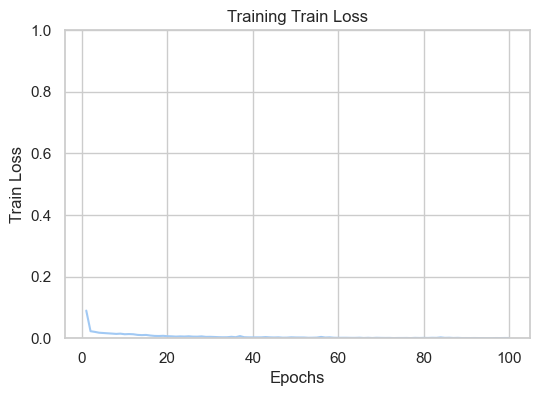

Epoch 1 Test


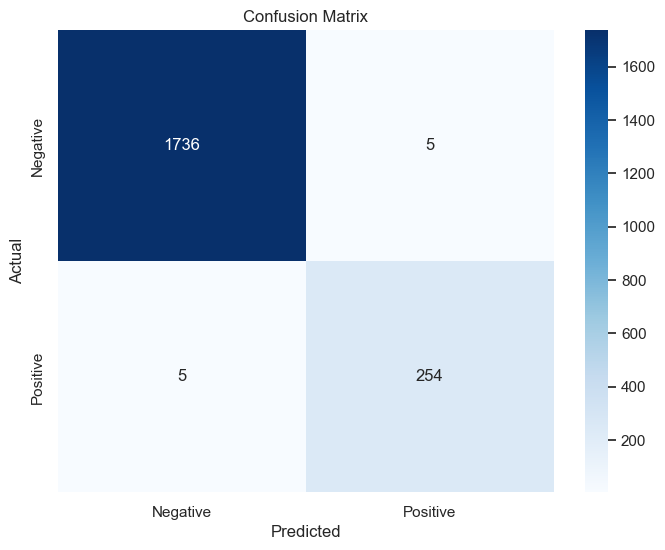

In [141]:
sampler = None
params = None
learning_rate = 0.01
epochs = 100
# Not saving.
save_factor = 1000
model_ep3.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_ep3.test(test_loader)
plot_metrics(model_ep3.train_loss, len(model_ep3.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_ep3.test_predicted)

# Dense Layer Size at 0.01 Learning Rate and 10 Epochs

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_fc1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 222.43batch/s]


Epoch [1/10], Train Loss: 0.0873, Train Acc: 0.9665, Train F1: 0.9591


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 237.19batch/s]


Epoch [2/10], Train Loss: 0.0220, Train Acc: 0.9895, Train F1: 0.9894


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 221.68batch/s]


Epoch [3/10], Train Loss: 0.0189, Train Acc: 0.9908, Train F1: 0.9908


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 180.51batch/s]


Epoch [4/10], Train Loss: 0.0180, Train Acc: 0.9916, Train F1: 0.9914


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 170.42batch/s]


Epoch [5/10], Train Loss: 0.0161, Train Acc: 0.9919, Train F1: 0.9919


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 172.97batch/s]


Epoch [6/10], Train Loss: 0.0163, Train Acc: 0.9926, Train F1: 0.9925


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 177.40batch/s]


Epoch [7/10], Train Loss: 0.0136, Train Acc: 0.9931, Train F1: 0.9930


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 174.98batch/s]


Epoch [8/10], Train Loss: 0.0134, Train Acc: 0.9931, Train F1: 0.9930


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 173.82batch/s]


Epoch [9/10], Train Loss: 0.0117, Train Acc: 0.9942, Train F1: 0.9941


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 182.72batch/s]


Epoch [10/10], Train Loss: 0.0112, Train Acc: 0.9950, Train F1: 0.9950


Testing: 100%|██████████| 16/16 [00:00<00:00, 308.92batch/s]

Test Loss: 0.0293, Test Accuracy: 0.9892, Test F1: 0.9895


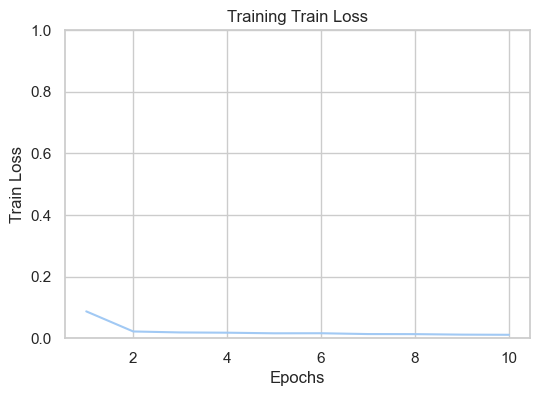

Epoch 1 Test


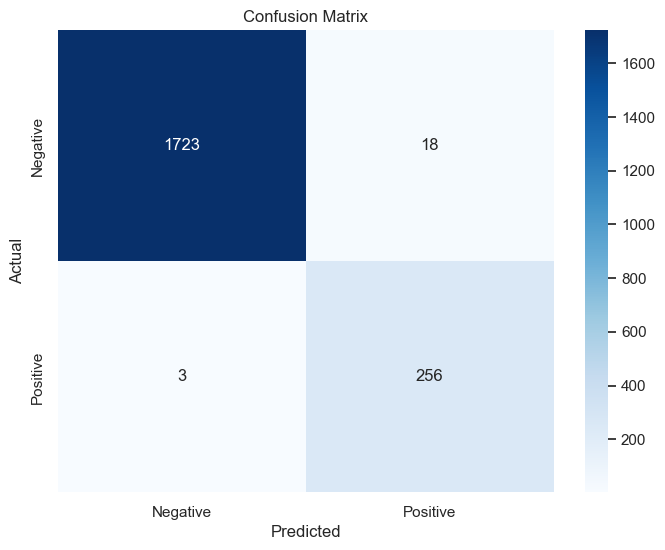

In [143]:
sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc1.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_fc1.test(test_loader)
plot_metrics(model_fc1.train_loss, len(model_fc1.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc1.test_predicted)

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 1024
save_dir = './Models/saved_models/'
model_fc2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 143.23batch/s]


Epoch [1/10], Train Loss: 0.0647, Train Acc: 0.9737, Train F1: 0.9690


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 150.18batch/s]


Epoch [2/10], Train Loss: 0.0209, Train Acc: 0.9898, Train F1: 0.9897


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 166.38batch/s]


Epoch [3/10], Train Loss: 0.0186, Train Acc: 0.9921, Train F1: 0.9920


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 181.98batch/s]


Epoch [4/10], Train Loss: 0.0185, Train Acc: 0.9911, Train F1: 0.9911


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 171.43batch/s]


Epoch [5/10], Train Loss: 0.0163, Train Acc: 0.9919, Train F1: 0.9918


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 176.16batch/s]


Epoch [6/10], Train Loss: 0.0137, Train Acc: 0.9931, Train F1: 0.9930


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 187.74batch/s]


Epoch [7/10], Train Loss: 0.0137, Train Acc: 0.9940, Train F1: 0.9940


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 173.30batch/s]


Epoch [8/10], Train Loss: 0.0122, Train Acc: 0.9944, Train F1: 0.9944


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 178.43batch/s]


Epoch [9/10], Train Loss: 0.0131, Train Acc: 0.9937, Train F1: 0.9936


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 188.57batch/s]


Epoch [10/10], Train Loss: 0.0121, Train Acc: 0.9945, Train F1: 0.9945


Testing: 100%|██████████| 16/16 [00:00<00:00, 311.83batch/s]


Test Loss: 0.0196, Test Accuracy: 0.9924, Test F1: 0.9924


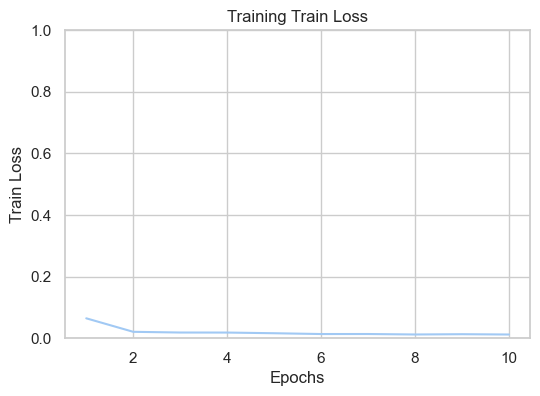

Epoch 1 Test


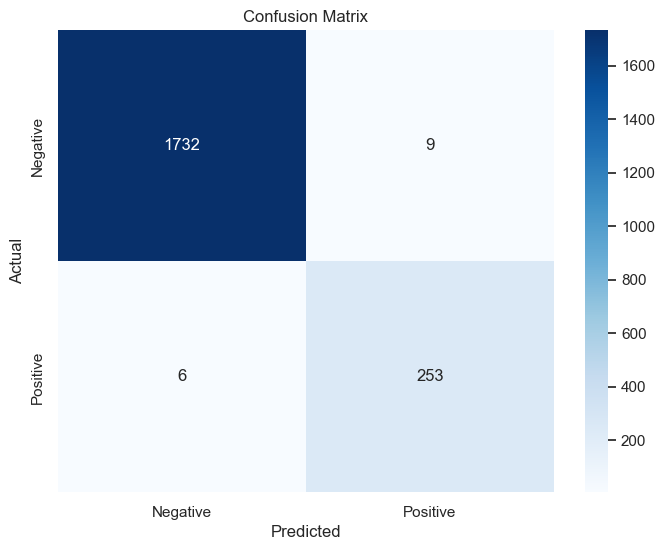

In [145]:
sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_fc2.test(test_loader)
plot_metrics(model_fc2.train_loss, len(model_fc2.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc2.test_predicted)

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 2048
save_dir = './Models/saved_models/'
model_fc3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 149.29batch/s]


Epoch [1/10], Train Loss: 0.0515, Train Acc: 0.9776, Train F1: 0.9742


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 172.86batch/s]


Epoch [2/10], Train Loss: 0.0228, Train Acc: 0.9882, Train F1: 0.9882


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 173.00batch/s]


Epoch [3/10], Train Loss: 0.0182, Train Acc: 0.9914, Train F1: 0.9914


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 162.92batch/s]


Epoch [4/10], Train Loss: 0.0172, Train Acc: 0.9906, Train F1: 0.9904


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 167.61batch/s]


Epoch [5/10], Train Loss: 0.0160, Train Acc: 0.9918, Train F1: 0.9918


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 162.49batch/s]


Epoch [6/10], Train Loss: 0.0149, Train Acc: 0.9924, Train F1: 0.9924


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 167.73batch/s]


Epoch [7/10], Train Loss: 0.0138, Train Acc: 0.9942, Train F1: 0.9941


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 165.03batch/s]


Epoch [8/10], Train Loss: 0.0130, Train Acc: 0.9937, Train F1: 0.9936


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 161.51batch/s]


Epoch [9/10], Train Loss: 0.0125, Train Acc: 0.9940, Train F1: 0.9940


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 155.99batch/s]


Epoch [10/10], Train Loss: 0.0107, Train Acc: 0.9954, Train F1: 0.9954


Testing: 100%|██████████| 16/16 [00:00<00:00, 257.87batch/s]

Test Loss: 0.0195, Test Accuracy: 0.9919, Test F1: 0.9917


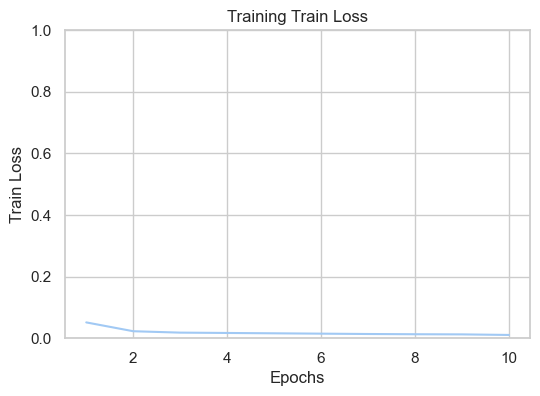

Epoch 1 Test


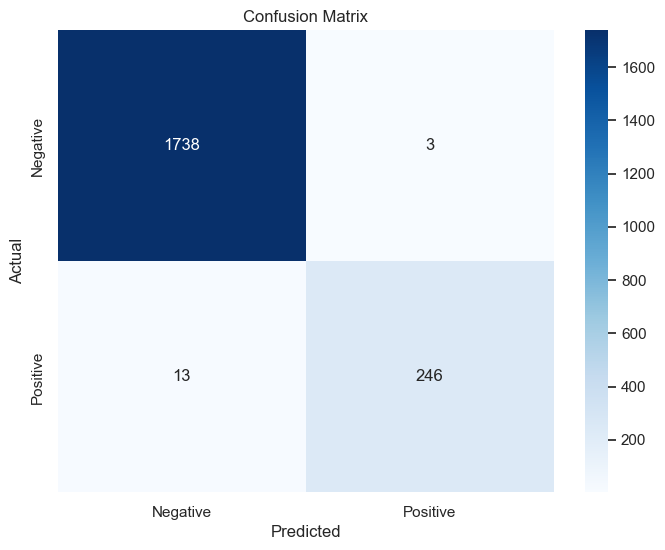

In [147]:
sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc3.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_fc3.test(test_loader)
plot_metrics(model_fc3.train_loss, len(model_fc3.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc3.test_predicted)

# SHAP Comparison

# None seem to have a significant impact provided we sample through the explainer.

Learning Rate

In [ ]:
# LR 0.1
# 28.7 seconds
xp_lr1 = shap.GradientExplainer(model_lr1, X_test_tensor)
x = xp_lr1.shap_values(X_test_tensor)

In [ ]:
# LR 0.01
# 28.7 seconds
xp_lr2 = shap.GradientExplainer(model_lr2, X_test_tensor)
x = xp_lr2.shap_values(X_test_tensor)

In [ ]:
# LR 0.001
# 28.8 seconds
xp_lr3 = shap.GradientExplainer(model_lr3, X_test_tensor)
x = xp_lr3.shap_values(X_test_tensor)

Epochs

In [ ]:
# Epochs 10
# 28.4 seconds
xp_ep1 = shap.GradientExplainer(model_ep1, X_test_tensor)
x = xp_ep1.shap_values(X_test_tensor)

In [ ]:
# Epochs 50
# 28.4 seconds
xp_ep2 = shap.GradientExplainer(model_ep2, X_test_tensor)
x = xp_ep2.shap_values(X_test_tensor)

In [ ]:
# Epochs 100
# 28.8 seconds
xp_ep3 = shap.GradientExplainer(model_ep3, X_test_tensor)
x = xp_ep3.shap_values(X_test_tensor)

Dense Layers - this seems to increase complexity with layer size.

In [ ]:
# FC 128
# 28.5 seconds
xp_fc1 = shap.GradientExplainer(model_fc1, X_test_tensor)
x = xp_fc1.shap_values(X_test_tensor)

In [ ]:
# FC 1024
# 34.6 seconds
xp_fc2 = shap.GradientExplainer(model_fc2, X_test_tensor)
x = xp_fc2.shap_values(X_test_tensor)

In [ ]:
# FC 2048
# 36.3 seconds
xp_fc3 = shap.GradientExplainer(model_fc3, X_test_tensor)
x = xp_fc3.shap_values(X_test_tensor)

One more extreme layer. - Yes it does increase time.

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 8192
save_dir = './Models/saved_models/'
model_fc4 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 77.15batch/s]


Epoch [1/10], Train Loss: 0.0737, Train Acc: 0.9748, Train F1: 0.9718


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 76.55batch/s]


Epoch [2/10], Train Loss: 0.0208, Train Acc: 0.9909, Train F1: 0.9908


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 78.60batch/s]


Epoch [3/10], Train Loss: 0.0204, Train Acc: 0.9902, Train F1: 0.9901


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 78.50batch/s]


Epoch [4/10], Train Loss: 0.0179, Train Acc: 0.9912, Train F1: 0.9911


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 78.38batch/s]


Epoch [5/10], Train Loss: 0.0165, Train Acc: 0.9921, Train F1: 0.9920


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 78.45batch/s]


Epoch [6/10], Train Loss: 0.0150, Train Acc: 0.9926, Train F1: 0.9925


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 77.03batch/s]


Epoch [7/10], Train Loss: 0.0147, Train Acc: 0.9927, Train F1: 0.9925


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 78.52batch/s]


Epoch [8/10], Train Loss: 0.0116, Train Acc: 0.9944, Train F1: 0.9944


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 77.73batch/s]


Epoch [9/10], Train Loss: 0.0116, Train Acc: 0.9949, Train F1: 0.9949


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 77.53batch/s]


Epoch [10/10], Train Loss: 0.0124, Train Acc: 0.9943, Train F1: 0.9942


Testing: 100%|██████████| 16/16 [00:00<00:00, 180.05batch/s]


Test Loss: 0.0191, Test Accuracy: 0.9917, Test F1: 0.9915


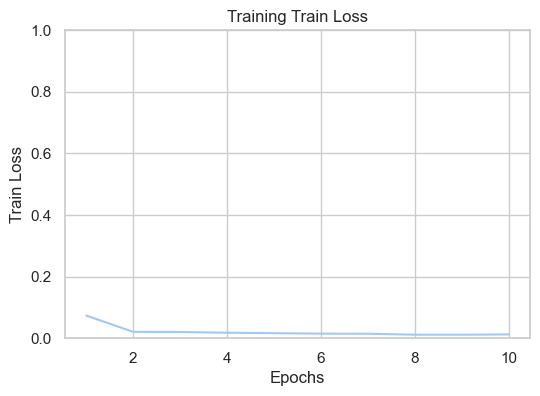

Epoch 1 Test


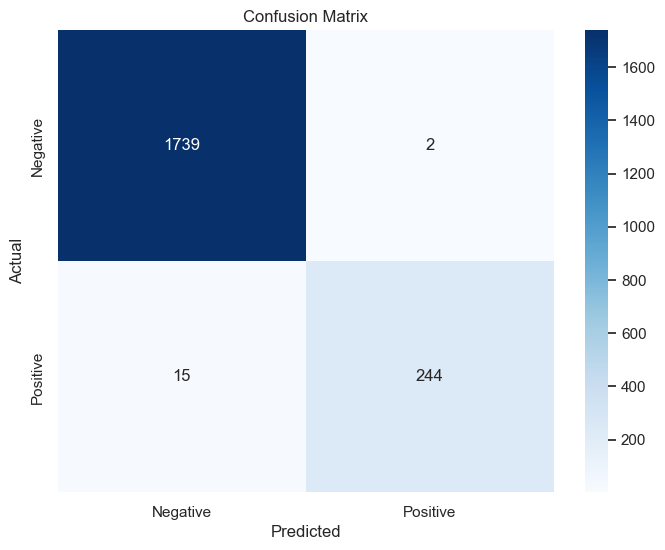

In [158]:
sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc4.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model_fc4.test(test_loader)
plot_metrics(model_fc4.train_loss, len(model_fc4.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc4.test_predicted)

In [ ]:
# FC 8192
# 48.3 seconds
xp_fc4 = shap.GradientExplainer(model_fc4, X_test_tensor)
x = xp_fc4.shap_values(X_test_tensor)

# Random Forest

Number of Estimators directly impacts the length of shap calculation along with the probability of shapely values calculating up to the baseline.

500 estimators

In [ ]:
# 1.14 min
rf1 = RandomForestClassifier(n_estimators=500, random_state=42)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_test)
xp_rf1 = shap.TreeExplainer(rf1, X_test)
# Sparse data error.
x = xp_rf1.shap_values(X_test, check_additivity=False)

 99%|===================| 3957/4000 [01:12<00:00]        

In [ ]:
# 14.2 seconds
rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
xp_rf2 = shap.TreeExplainer(rf2, X_test)
# Sparse data error.
x = xp_rf2.shap_values(X_test, check_additivity=False)

 93%|=================== | 3701/4000 [00:13<00:01]       

In [ ]:
# 1.1 seconds
rf3 = RandomForestClassifier(n_estimators=10, random_state=42)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_test)
xp_rf3 = shap.TreeExplainer(rf3, X_test)
x = xp_rf3.shap_values(X_test)